# Set Deterministic Training

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import os
import numpy as np
import pandas as pd
import random
from glob import glob
from time import time
from functools import partial
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives, TruePositives, TrueNegatives, Precision, Recall, AUC
import matplotlib.pyplot as plt
import seaborn as sn
from preprocessing import LABELS
SAMPLE_POINTS = 56000

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

DIR_NAME = 'Mini-CREMA-80-10-10-split-oversampled-balanced'
filename = f'./{DIR_NAME}/test/1001_WSI_HAP_XX.wav'
# filename = f'./augment11001_DFA_NEU_XX.wav'

2023-03-21 14:18:27.226274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 14:18:27.505638: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 14:18:27.517093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 14:18:27.517119: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Define Hyper-Parameters

In [2]:
PREPROCESSING_ARGS = {
    'downsampling_rate': 16000,
    'frame_length_in_s': 0.016,
    'frame_step_in_s': 0.016,
    'lower_frequency': 20,
    'upper_frequency': 4000,
    'num_mel_bins': 40,
    'num_coefficients': 10
}
TRAINING_ARGS = {
    'batch_size': 20,
    'initial_learning_rate': 0.01, 
    'end_learning_rate': 1.e-5,
    'epochs': 40
}

#Model parameters
conv_layer_number = 5
conv_layer_1 = 256 #CHANGE MANUALLY IF MORE LAYERS ADDED
conv_layer_2 = 256
conv_layer_3 = 256
conv_layer_4 = 256
conv_layer_5 = 256
conv_layer_6 = 0
conv_layer_7 = 0
conv_layer_8 = 0
conv_layer_9 = 0
conv_layer_10 = 0

#Optimization parameter
alpha = 0.5
final_sparsity = 0.5



# Create Train/Val/Test Datasets

In [3]:
train_ds = tf.data.Dataset.list_files(f'{DIR_NAME}/train/*.wav')
test_ds = tf.data.Dataset.list_files(f'{DIR_NAME}/test/*.wav')
val_ds = tf.data.Dataset.list_files(f'{DIR_NAME}/val/*.wav')

2023-03-17 12:47:39.854390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-17 12:47:39.854420: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-17 12:47:39.854438: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-0251bcdd-4ed1-43c6-b2b4-37ee69274d9e): /proc/driver/nvidia/version does not exist
2023-03-17 12:47:39.854761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Defining the preprocess function

In [4]:
LABELS = ['ANG', 'HAP','NEU']

def get_audio_and_label(filename):
    sample_points = 56000
    audio_binary = tf.io.read_file(filename)
    audio, sampling_rate = tf.audio.decode_wav(audio_binary) 

    path_parts = tf.strings.split(filename, '/')
    # print(path_parts)
    path_end = path_parts[-1]
    # print(path_end)
    file_parts = tf.strings.split(path_end, '_')
    label = file_parts[-2]
    
    audio = tf.squeeze(audio)
    audio = audio[:sample_points]

    zero_padding = tf.zeros(sample_points - tf.shape(audio), dtype=tf.float32)
    audio_padded = tf.concat([audio, zero_padding], axis=0)
    audio = audio_padded

    return audio, sampling_rate, label

In [5]:
def get_spectrogram(filename, downsampling_rate, frame_length_in_s, frame_step_in_s):
    audio_padded, sampling_rate, label = get_audio_and_label(filename)
    
    if downsampling_rate != sampling_rate:
        sampling_rate_int64 = tf.cast(sampling_rate, tf.int64)
        audio_padded = tfio.audio.resample(audio_padded, sampling_rate_int64, downsampling_rate)

    sampling_rate_float32 = tf.cast(downsampling_rate, tf.float32)
    frame_length = int(frame_length_in_s * sampling_rate_float32)
    frame_step = int(frame_step_in_s * sampling_rate_float32)

    spectrogram = stft = tf.signal.stft(
        audio_padded, 
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )
    spectrogram = tf.abs(stft)

    return spectrogram, downsampling_rate, label

In [6]:
spectrogram, sampling_rate, label = get_spectrogram(filename, 16000, 0.016, 0.016)
print(spectrogram.shape)
print(sampling_rate)
print(label)

(218, 129)
16000
tf.Tensor(b'HAP', shape=(), dtype=string)


In [7]:
def get_log_mel_spectrogram(filename, downsampling_rate, frame_length_in_s, frame_step_in_s, num_mel_bins, lower_frequency, upper_frequency):
    spectrogram, sampling_rate, label = get_spectrogram(filename, downsampling_rate, frame_length_in_s, frame_step_in_s)

    sampling_rate_float32 = tf.cast(sampling_rate, tf.float32)
    frame_length = int(frame_length_in_s * sampling_rate_float32)
    num_spectrogram_bins = frame_length // 2 + 1

    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix( 
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=sampling_rate,
        lower_edge_hertz=lower_frequency,
        upper_edge_hertz=upper_frequency
    )

    mel_spectrogram = tf.matmul(spectrogram, linear_to_mel_weight_matrix)

    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)

    return log_mel_spectrogram, label


In [8]:
log_mel_spectrogram, label = get_log_mel_spectrogram(filename, 16000, 0.016, 0.016,40, 20, 4000)
print(log_mel_spectrogram.shape)
print(label)

(218, 40)
tf.Tensor(b'HAP', shape=(), dtype=string)


In [9]:
def get_mfccs(filename, downsampling_rate, frame_length_in_s, frame_step_in_s, num_mel_bins, lower_frequency, upper_frequency, num_coefficients):
    #First you obtain the log_mel_spectrogram
    log_mel_spectrogram, label = get_log_mel_spectrogram(filename, downsampling_rate, frame_length_in_s, frame_step_in_s, num_mel_bins, lower_frequency, upper_frequency)
    
    #Compute the mfccs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    
    #Reshapping the mfccs in order to have only the desired coefficients
    mfccs = mfccs[..., :num_coefficients]
    return mfccs, label

In [10]:
mfccs, label = get_mfccs(filename, 16000, 0.016, 0.016,40, 20, 4000,10)
print(mfccs.shape)
print(label)

(218, 10)
tf.Tensor(b'HAP', shape=(), dtype=string)


## Define the preprocessing function to apply to the dataset

In [11]:

def get_mfccs_and_label(filename, downsampling_rate, frame_length_in_s, frame_step_in_s, num_mel_bins, lower_frequency, upper_frequency, num_coefficients):
    mfccs, label = get_mfccs(filename,
                            downsampling_rate,
                            frame_length_in_s,
                            frame_step_in_s,
                            num_mel_bins,
                            lower_frequency,
                            upper_frequency,
                            num_coefficients
                            )
    
    return mfccs, label



#Parameter freezing
get_frozen_mfccs = partial(get_mfccs_and_label, **PREPROCESSING_ARGS)


In [12]:
def preprocess(filename):
    #Get mfccs and then expand the dimension to then pass it to the model
    processed_signal, label = get_frozen_mfccs(filename)
    processed_signal = tf.expand_dims(processed_signal,-1) #because we need a 3d tensor for the model input

    label_id = tf.argmax(label == LABELS)

    return processed_signal, label_id

In [13]:
signal, label = preprocess(filename)
print(signal.shape)
print(label)

(218, 10, 1)
tf.Tensor(1, shape=(), dtype=int64)


In [14]:
batch_size = TRAINING_ARGS['batch_size']
epochs = TRAINING_ARGS['epochs']

train_ds = train_ds.map(preprocess).batch(batch_size).cache()
val_ds = val_ds.map(preprocess).batch(batch_size)
test_ds = test_ds.map(preprocess).batch(batch_size)

2023-03-17 12:47:40.774759: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2023-03-17 12:47:40.774973: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2023-03-17 12:47:41.213616: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-03-17 12:47:41.215203: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-03-17 12:47:41.215418: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-03-17 12:47:41.564972: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-03-17 12:47:41.566564: W tensorflow/core/framework/op_kernel.cc:1780] O

In [15]:
for example_batch, example_labels in train_ds.take(1):
  print('Batch Shape:', example_batch.shape)
  print('Data Shape:', example_batch.shape[1:])
  print('Labels:', example_labels)

Batch Shape: (20, 218, 10, 1)
Data Shape: (218, 10, 1)
Labels: tf.Tensor([2 1 0 2 0 2 1 1 0 0 1 0 0 0 0 0 1 2 0 2], shape=(20,), dtype=int64)
2023-03-17 12:47:42.485175: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Create the Model HAS MORE LAYERS

In [16]:

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=example_batch.shape[1:]),
    
    # ----------------------- Normal convolution  ------------------------------------------
    tf.keras.layers.Conv2D(filters=int(conv_layer_1 * alpha), kernel_size=[3, 3], strides=[2, 2],
        use_bias=False, padding='valid'),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.ReLU(),
    # ----------------------- Depth wise convolution 1 ------------------------------------------
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], 
        use_bias=False, padding='same'),
    
    tf.keras.layers.Conv2D(filters=int(conv_layer_2 * alpha), kernel_size=[1, 1], strides=[1, 1],   
       use_bias=False),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.ReLU(),

    # ----------------------- Depth wise convolution 2 ------------------------------------------
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], 
        use_bias=False, padding='same'),
    
    tf.keras.layers.Conv2D(filters=int(conv_layer_3 * alpha), kernel_size=[1, 1], strides=[1, 1],   
       use_bias=False),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.ReLU(),

    # ----------------------- Depth wise convolution 3 ------------------------------------------
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], 
        use_bias=False, padding='same'),
    
    tf.keras.layers.Conv2D(filters=int(conv_layer_4 * alpha), kernel_size=[1, 1], strides=[1, 1],   
       use_bias=False),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.ReLU(),


    # ----------------------- Final convolution ------------------------------------------    
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1],
        use_bias=False, padding='same'),
    
    tf.keras.layers.Conv2D(filters=int(conv_layer_5 * alpha), kernel_size=[1, 1], strides=[1, 1],   
       use_bias=False),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(units=len(LABELS)),
    
    tf.keras.layers.Softmax()
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 108, 4, 128)       1152      
                                                                 
 batch_normalization (BatchN  (None, 108, 4, 128)      512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 108, 4, 128)       0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 108, 4, 128)      1152      
 Conv2D)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 4, 128)       16384     
                                                                 
 batch_normalization_1 (Batc  (None, 108, 4, 128)      5

## Setup Magnitude-based Weights Pruning

In [18]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

begin_step = int(len(train_ds) * epochs * 0.2)
end_step = int(len(train_ds) * epochs)

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.20,
        final_sparsity=final_sparsity,
        begin_step=begin_step,
        end_step=end_step
    )
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)
model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 108, 4, 128)      2306      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_batch_n  (None, 108, 4, 128)      513       
 ormalization (PruneLowMagni                                     
 tude)                                                           
                                                                 
 prune_low_magnitude_re_lu (  (None, 108, 4, 128)      1         
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_depthwi  (None, 108, 4, 128)      1153      
 se_conv2d (PruneLowMagnitud                                     
 e)                                                     

## Train the model

In [19]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
initial_learning_rate = TRAINING_ARGS['initial_learning_rate']
end_learning_rate = TRAINING_ARGS['end_learning_rate']

linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=end_learning_rate,
    decay_steps=len(train_ds) * epochs,
)
optimizer = tf.optimizers.Adam(learning_rate=linear_decay)
metrics = [tf.metrics.SparseCategoricalAccuracy()]
callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

#Compiling and running the model
model_for_pruning.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model_for_pruning.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/40
155/155 [==============================] - 49s 286ms/step - loss: 0.8214 - sparse_categorical_accuracy: 0.6102 - val_loss: 6.6629 - val_sparse_categorical_accuracy: 0.3544
Epoch 2/40
155/155 [==============================] - 21s 136ms/step - loss: 0.7941 - sparse_categorical_accuracy: 0.6267 - val_loss: 45.5789 - val_sparse_categorical_accuracy: 0.3544
Epoch 3/40
155/155 [==============================] - 21s 138ms/step - loss: 0.7875 - sparse_categorical_accuracy: 0.6293 - val_loss: 12.9424 - val_sparse_categorical_accuracy: 0.3544
Epoch 4/40
155/155 [==============================] - 22s 140ms/step - loss: 0.7593 - sparse_categorical_accuracy: 0.6508 - val_loss: 1.1931 - val_sparse_categorical_accuracy: 0.4368
Epoch 5/40
155/155 [==============================] - 22s 141ms/step - loss: 0.7399 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.9065 - val_sparse_categorical_accuracy: 0.5824
Epoch 6/40
155/155 [==============================] - 21s 135ms/step - loss: 0.7265

In [20]:
# How each layer got pruned

for layer in model_for_pruning.layers:
    if isinstance(layer, tf.keras.layers.Wrapper):
        weights = layer.trainable_weights
    else:
        weights = layer.weights
    for weight in weights:        
        weight_size = weight.numpy().size
        zero_num = np.count_nonzero(weight == 0)
        print(
            f'{weight.name}: {zero_num/weight_size:.2%} sparsity ',
            f'({zero_num}/{weight_size})',
        )

conv2d/kernel:0: 50.00% sparsity  (576/1152)
batch_normalization/gamma:0: 0.00% sparsity  (0/128)
batch_normalization/beta:0: 0.00% sparsity  (0/128)
depthwise_conv2d/depthwise_kernel:0: 0.00% sparsity  (0/1152)
conv2d_1/kernel:0: 50.00% sparsity  (8192/16384)
batch_normalization_1/gamma:0: 0.00% sparsity  (0/128)
batch_normalization_1/beta:0: 0.00% sparsity  (0/128)
depthwise_conv2d_1/depthwise_kernel:0: 0.00% sparsity  (0/1152)
conv2d_2/kernel:0: 50.00% sparsity  (8192/16384)
batch_normalization_2/gamma:0: 0.00% sparsity  (0/128)
batch_normalization_2/beta:0: 0.00% sparsity  (0/128)
depthwise_conv2d_2/depthwise_kernel:0: 0.00% sparsity  (0/1152)
conv2d_3/kernel:0: 50.00% sparsity  (8192/16384)
batch_normalization_3/gamma:0: 0.00% sparsity  (0/128)
batch_normalization_3/beta:0: 0.00% sparsity  (0/128)
depthwise_conv2d_3/depthwise_kernel:0: 0.00% sparsity  (0/1152)
conv2d_4/kernel:0: 50.00% sparsity  (8192/16384)
batch_normalization_4/gamma:0: 0.00% sparsity  (0/128)
batch_normalizatio

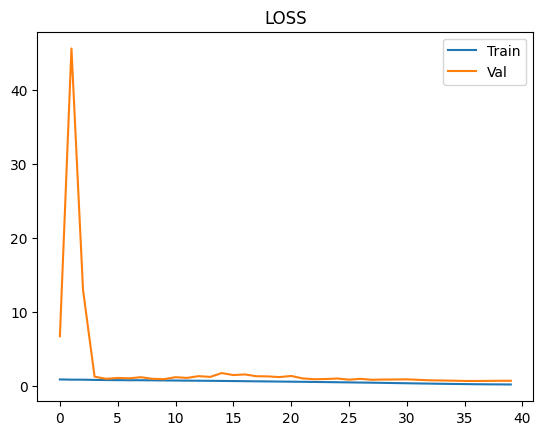

In [21]:
hh = history.history
plt.plot(hh['loss'])
plt.plot(hh['val_loss'])
plt.legend(['Train', 'Val'])
plt.title('LOSS')


plt.show()


Text(0.5, 1.0, 'Accuracy')

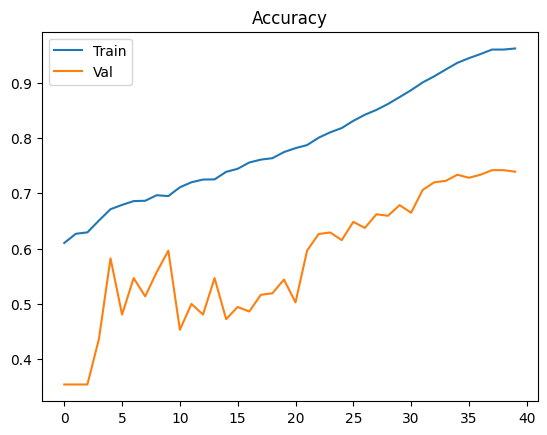

In [22]:
plt.plot(hh['sparse_categorical_accuracy'])
plt.plot(hh['val_sparse_categorical_accuracy'])
plt.legend(['Train', 'Val'])
plt.title('Accuracy')


## Test the model

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

# Get the predicted probabilities for each batch of images
y_pred = model.predict(test_ds)

# Compute the confusion matrix
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

recall = recall_score(y_true, np.argmax(y_pred, axis=1), average=None)


# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average=None)


# Print the results

print(cm)
print()
print(recall)
print()
print('Class 1 - Precision: {:.2f}, Recall: {:.2f}, F1 score: {:.2f}'.format(precision[0], recall[0], f1[0]))
print('Class 2 - Precision: {:.2f}, Recall: {:.2f}, F1 score: {:.2f}'.format(precision[1], recall[1], f1[1]))
print('Class 3 - Precision: {:.2f}, Recall: {:.2f}, F1 score: {:.2f}'.format(precision[2], recall[2], f1[2]))



19/19 [==============================] - 4s 166ms/step
[[58 41 39]
 [42 37 37]
 [35 31 42]]

[0.42028986 0.31896552 0.38888889]

Class 1 - Precision: 0.43, Recall: 0.42, F1 score: 0.42
Class 2 - Precision: 0.34, Recall: 0.32, F1 score: 0.33
Class 3 - Precision: 0.36, Recall: 0.39, F1 score: 0.37


Text(0.5, 1.0, 'Confusion Matrix - Test dataset')

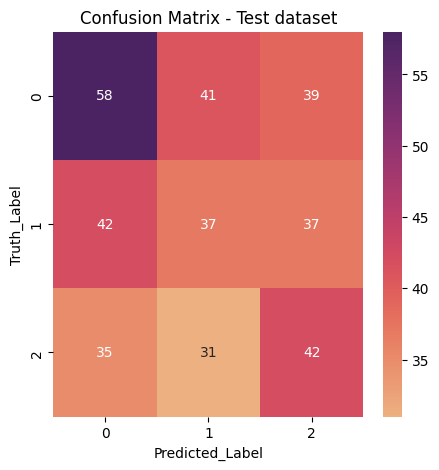

In [24]:
plt.figure(figsize = (5,5))
# were 'cmap' is used to set the accent colour
sn.heatmap(cm, annot=True, cmap= 'flare',  fmt='d', cbar=True)
plt.xlabel('Predicted_Label')
plt.ylabel('Truth_Label')
plt.title('Confusion Matrix - Test dataset')

In [25]:
test_loss, test_accuracy = model_for_pruning.evaluate(test_ds)

19/19 [==============================] - 4s 162ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7956


In [26]:
training_loss = history.history['loss'][-1]
training_accuracy = history.history['sparse_categorical_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_sparse_categorical_accuracy'][-1]

print(f'Weight pruning with final_sparsity= {final_sparsity} and alpha = {alpha}')
print(f'Training Loss: {training_loss:.4f}')
print(f'Training Accuracy: {training_accuracy*100.:.2f}%')
print()
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy*100.:.2f}%')
print()
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100.:.2f}%')


Weight pruning with final_sparsity= 0.5 and alpha = 0.5
Training Loss: 0.1415
Training Accuracy: 96.17%

Validation Loss: 0.6427
Validation Accuracy: 73.90%

Test Loss: 0.6344
Test Accuracy: 79.56%


## Save the Model as TFLite

In [27]:
from time import time

timestamp = int(time())

saved_model_dir = f'./saved_models/{timestamp}'
if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)
model.save(saved_model_dir)

INFO:tensorflow:Assets written to: ./saved_models/1679058323/assets
INFO:tensorflow:Assets written to: ./saved_models/1679058323/assets


In [28]:
MODEL_NAME = timestamp
converter = tf.lite.TFLiteConverter.from_saved_model(f'./saved_models/{MODEL_NAME}')
tflite_model = converter.convert()

tflite_models_dir = './tflite_models'
if not os.path.exists(tflite_models_dir):
    os.makedirs(tflite_models_dir)

tflite_model_name = os.path.join(tflite_models_dir, f'{MODEL_NAME}.tflite')
with open(tflite_model_name, 'wb') as fp:
    fp.write(tflite_model)

!ls tflite_models

2023-03-17 13:05:25.903135: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-17 13:05:25.903171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-17 13:05:25.904149: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ./saved_models/1679058323
2023-03-17 13:05:25.913921: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-17 13:05:25.913956: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ./saved_models/1679058323
2023-03-17 13:05:25.940821: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-03-17 13:05:25.946682: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-17 13:05:26.022544: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: ./save

In [29]:
import zipfile

tflite_model_name = os.path.join(tflite_models_dir, f'{MODEL_NAME}.tflite')

with zipfile.ZipFile(f'{tflite_model_name}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(tflite_model_name)

In [30]:
tflite_size = os.path.getsize(tflite_model_name) / 1024.0
zipped_size = os.path.getsize(f'{tflite_model_name}.zip') / 1024.0

print(f'Original tflite size: {tflite_size:.3f} KB')
print(f'Zipped tflite size : {zipped_size:.3f} KB')

Original tflite size: 288.352 KB
Zipped tflite size : 174.918 KB


## Load the TFLite model and test it 

In [31]:
interpreter = tf.lite.Interpreter(model_path=f'tflite_models/{MODEL_NAME}.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Number of inputs:", len(input_details))
print("Number of outputs:", len(output_details))
print("Input name:", input_details[0]['name'])
print("Input shape:", input_details[0]['shape'])
print("Output name:", output_details[0]['name'])
print("Output shape:", output_details[0]['shape'])

Number of inputs: 1
Number of outputs: 1
Input name: serving_default_input_1:0
Input shape: [  1 218  10   1]
Output name: StatefulPartitionedCall:0
Output shape: [1 3]
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [32]:
from glob import glob
from time import time

filenames = glob(f'{DIR_NAME}/test/*.wav')

frame_length = PREPROCESSING_ARGS['frame_length_in_s'] * PREPROCESSING_ARGS['downsampling_rate']
num_spectrogram_bins = frame_length // 2 + 1
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix( 
    num_mel_bins=int(PREPROCESSING_ARGS['num_mel_bins']),
    num_spectrogram_bins=int(num_spectrogram_bins),
    sample_rate=int(PREPROCESSING_ARGS['downsampling_rate']),
    lower_edge_hertz=int(PREPROCESSING_ARGS['lower_frequency']),
    upper_edge_hertz=int(PREPROCESSING_ARGS['upper_frequency'])
)

avg_preprocessing_latency = 0.0
avg_model_latency = 0.0
latencies = []
accuracy = 0.0
counter = 0
sample_points = SAMPLE_POINTS

for filename in filenames:
    counter +=1
    #This finds the label to predict
    audio_binary = tf.io.read_file(filename)
    path_parts = tf.strings.split(filename, '/')
    # print(path_parts)
    path_end = path_parts[-1]
    # print(path_end)
    file_parts = tf.strings.split(path_end, '_')
    true_label = file_parts[-2]
    true_label = true_label.numpy().decode()


    # Starts the measurement for the inference part
    start_preprocess = time()
    #...here you insert all the preprocessing steps...
    audio, sampling_rate = tf.audio.decode_wav(audio_binary)     
    audio = tf.squeeze(audio)
    audio = audio[:sample_points]
    zero_padding = tf.zeros(sample_points - tf.shape(audio), dtype=tf.float32)
    audio_padded = tf.concat([audio, zero_padding], axis=0)
    audio = audio_padded
    
    #if downsampling_rate != sampling_rate:
        #sampling_rate_int64 = tf.cast(sampling_rate, tf.int64)
        #audio_padded = tfio.audio.resample(audio_padded, sampling_rate_int64, downsampling_rate)

    stft = tf.signal.stft(
        audio_padded, 
        frame_length =int(PREPROCESSING_ARGS['frame_length_in_s'] * PREPROCESSING_ARGS['downsampling_rate']),
        frame_step=int(PREPROCESSING_ARGS['frame_step_in_s'] * PREPROCESSING_ARGS['downsampling_rate']),
        fft_length=int(PREPROCESSING_ARGS['frame_length_in_s'] * PREPROCESSING_ARGS['downsampling_rate'])
    )
    spectrogram = tf.abs(stft)

    mel_spectrogram = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
    #Compute the mfccs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    #Reshapping the mfccs in order to have only the desired coefficients
    mfccs = mfccs[..., :int(PREPROCESSING_ARGS['num_coefficients'])]
    mfccs = tf.expand_dims(mfccs, 0) 
    mfccs = tf.expand_dims(mfccs, -1)

    end_preprocess = time()

    interpreter.set_tensor(input_details[0]['index'], mfccs)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    end_inference = time()

    top_index = np.argmax(output[0])
    
    predicted_label = LABELS[top_index]

    accuracy += true_label == predicted_label
    avg_preprocessing_latency += end_preprocess - start_preprocess
    avg_model_latency += end_inference - end_preprocess
    latencies.append(end_inference - start_preprocess)


accuracy /= len(filenames)
avg_preprocessing_latency /= len(filenames)
avg_model_latency /= len(filenames)
median_total_latency = np.median(latencies)

print(f'Accuracy: {100 * accuracy:.3f}%')
#Unzipped size
model_size = os.path.getsize(f'tflite_models/{MODEL_NAME}.tflite')
print(f'Model size: {model_size / 2 ** 10:.1f}KB')
#Zipped size
zipped_size = os.path.getsize(f'{tflite_model_name}.zip') / 1024.0
print(f'Zipped tflite size : {zipped_size:.3f} KB')

print(f'Preprocessing Latency (avg): {1000 * avg_preprocessing_latency:.1f}ms')
print(f'Model Latency (avg): {1000 * avg_model_latency:.1f}ms')
print(f'Total Latency (median): {1000 * median_total_latency:.1f}ms')
print(f'File computed are {counter} ')

Accuracy: 79.558%
Model size: 288.4KB
Zipped tflite size : 174.918 KB
Preprocessing Latency (avg): 16.0ms
Model Latency (avg): 1.4ms
Total Latency (median): 15.0ms
File computed are 362 


In [33]:
output_dict = {
    'dataset_used': DIR_NAME,
    'alpha' : alpha,
    'final_sparsity': final_sparsity,
    'convolution_layers': conv_layer_number,
    'timestamp': timestamp,
    **PREPROCESSING_ARGS,
    **TRAINING_ARGS,
    'test_accuracy': test_accuracy,
    'test_accuracy_of_zipped': accuracy,
    'Model size': f'{model_size / 2 ** 10:.1f}KB',
    'Zipped tflite size' : f'Zipped tflite size : {zipped_size:.3f} KB',
    'Preprocessing Latency (avg)': f'{1000 * avg_preprocessing_latency:.1f}ms',
   ' Model Latency (avg)': f'{1000 * avg_model_latency:.1f}ms',
    'Total Latency (median)': f'{1000 * median_total_latency:.1f}ms',
    'conv_layer_number' : conv_layer_number,
    'layer_1' : conv_layer_1,
    'layer_2' : conv_layer_2,
    'layer_3' : conv_layer_3,
    'layer_4' : conv_layer_4,
    'layer_5' : conv_layer_5,
    'layer_6' : conv_layer_6,
    'layer_7' : conv_layer_7,
    'layer_8' : conv_layer_8,
    'layer_9' : conv_layer_9,
    'layer_10' : conv_layer_10
}

df = pd.DataFrame([output_dict])

output_path='./CNN_results_new.csv'
df.to_csv(output_path, mode='a', header=not os.path.exists(output_path), index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f648dc53-4e62-47c1-9023-194409755340' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>